In [2]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

pd.set_option('max_rows', 300)
pd.set_option('max_columns', 150)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

#### Check open interest

In [3]:
startTm = datetime.datetime.now()

readPath = r'\\192.168.10.30\Kevin_zhenyu\tickData_cffex\OI\minOIData_IC'
dataPathLs = glob.glob(os.path.join(readPath, 'IC***.csv.gz'))
oiData = []
for path in dataPathLs:
    data = pd.read_csv(path, compression='gzip')
    oiData += [data]
oiData = pd.concat(oiData).reset_index(drop=True)
oiData.columns = ['time', 'oi', 'contract']
oiData['time'] = oiData['time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
oiData['date'] = oiData.time.dt.date
oiData = oiData.groupby(['contract', 'date'])['oi'].mean().reset_index()
oiData['totalOI'] = oiData.groupby(['date'])['oi'].transform('sum')

readPath = r'\\192.168.10.30\Kevin_zhenyu\tickData_cffex\OI'
expiryData = pd.read_csv(os.path.join(readPath, 'expiryTable.csv'))
expiryData['contract'] = 'IC' + expiryData['contr_name'].str.slice(5)
expiryData['expDate'] = expiryData['expDate'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())

# contractLs = sorted(expiryData['contract'].unique())
# nextContractDict = dict(zip(contractLs[:-1], contractLs[1:]))

expiryData = expiryData[(expiryData['expDate'] <= datetime.date(2019, 10, 18))]
consData = pd.DataFrame({'date': sorted(oiData['date'].unique())})
consData['consDay'] = consData.index.values
consData = dict(zip(consData['date'], consData['consDay']))

expiryData['expConsDay'] = expiryData['expDate'].apply(lambda x: consData[x])
expiryData = expiryData[['contract', 'expDate', 'expConsDay']]

oiData['consDay'] = oiData['date'].apply(lambda x: consData[x])
oiData = pd.merge(oiData, expiryData, how='left', on=['contract'], validate='many_to_one')
oiData['remainDays'] = oiData['consDay'] - oiData['expConsDay']
# oiData['nextContract'] = oiData['contract'].apply(lambda x: nextContractDict[x])

# nextContractData = oiData[['contract', 'date', 'oi']].reset_index(drop=True)
# nextContractData.columns = ['nextContract', 'date', 'nextOI']
# oiData = pd.merge(oiData, nextContractData, how='left', on=['nextContract', 'date'])

oiData = oiData[oiData['contract'] <= 'IC1910'].reset_index(drop=True)
oiData = oiData[oiData['remainDays'] >= -20]
# oiData['frontOI'] = oiData['oi'] / (oiData['oi'] + oiData['nextOI'])
# oiData['totalOI'] = oiData['oi'] + oiData['nextOI']
oiData['frontOI'] = oiData['oi'] / oiData['totalOI']

print(datetime.datetime.now() - startTm)

0:00:05.170167


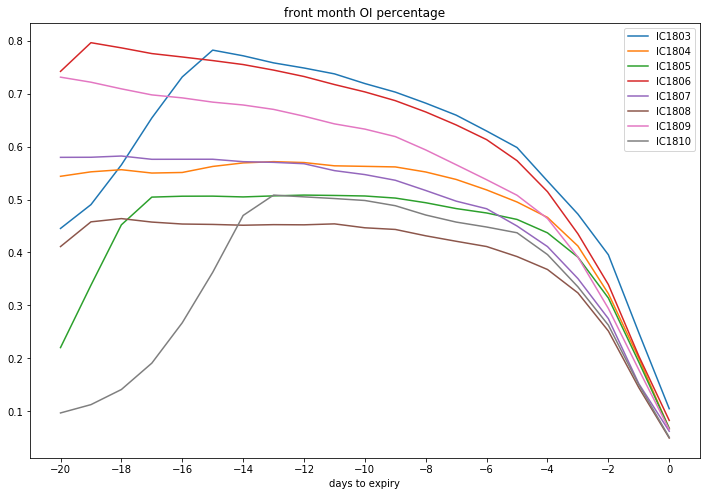

In [4]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for contract in oiData['contract'].unique()[-20:-12]:
    ax.plot(oiData[oiData['contract'] == contract]['remainDays'], oiData[oiData['contract'] == contract]['frontOI'], label=contract)

ax.set_xticks(np.arange(-20, 2, 2))
ax.set_xlabel('days to expiry')
ax.set_title('front month OI percentage')
ax.legend();

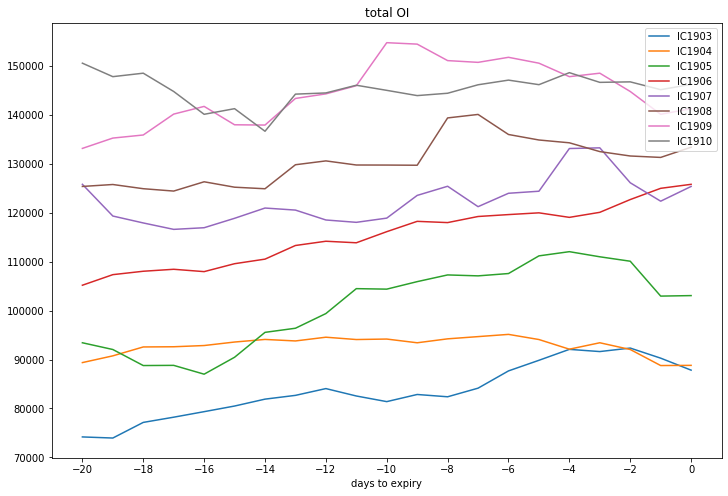

In [5]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for contract in oiData['contract'].unique()[-8:]:
    ax.plot(oiData[oiData['contract'] == contract]['remainDays'], oiData[oiData['contract'] == contract]['totalOI'], label=contract)

ax.set_xticks(np.arange(-20, 2, 2))
ax.set_xlabel('days to expiry')
ax.set_title('total OI')
ax.legend(loc='upper right');

Text(0.5,1,'total OI')

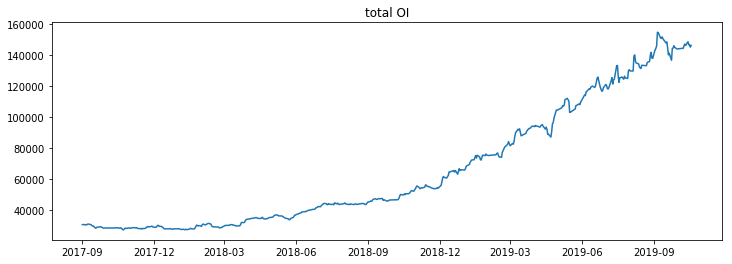

In [7]:
a = oiData.groupby(['date'])['totalOI'].mean().reset_index()

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

ax.plot(a['date'], a['totalOI'])

# ax.set_xticks(np.arange(-20, 2, 2))
# ax.set_xlabel('days to expiry')
ax.set_title('total OI')
# ax.legend();

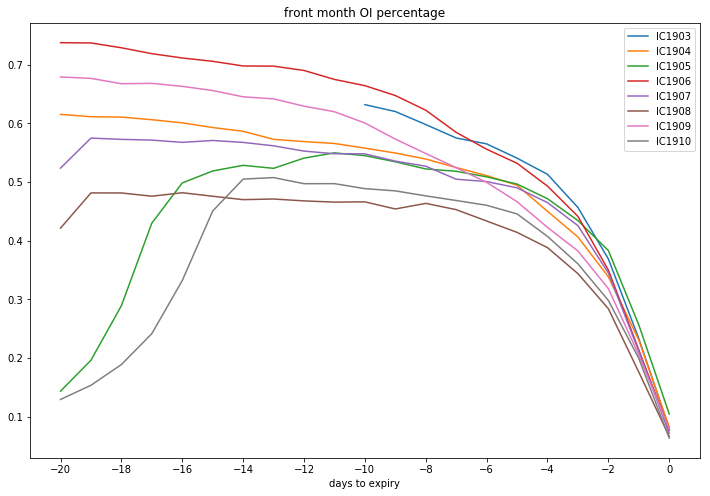

In [86]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for contract in oiData['contract'].unique():
    ax.plot(oiData[oiData['contract'] == contract]['remainDays'], oiData[oiData['contract'] == contract]['frontOI'], label=contract)

ax.set_xticks(np.arange(-20, 2, 2))
ax.set_xlabel('days to expiry')
ax.set_title('front month OI percentage')
ax.legend();

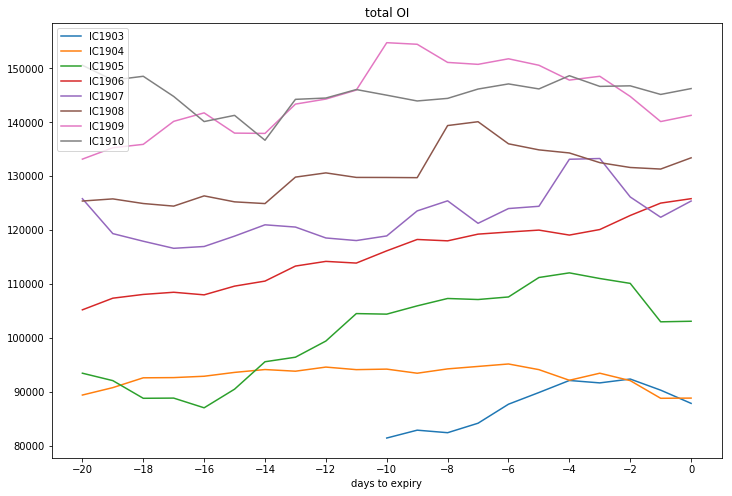

In [88]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for contract in oiData['contract'].unique():
    ax.plot(oiData[oiData['contract'] == contract]['remainDays'], oiData[oiData['contract'] == contract]['totalOI'], label=contract)

ax.set_xticks(np.arange(-20, 2, 2))
ax.set_xlabel('days to expiry')
ax.set_title('total OI')
ax.legend();

Text(0.5,1,'total OI')

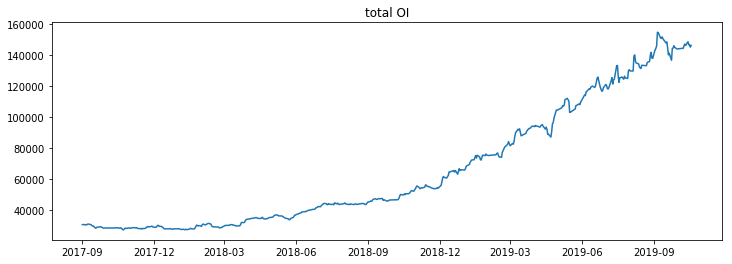

In [102]:
a = oiData.groupby(['date'])['totalOI'].mean().reset_index()

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

ax.plot(a['date'], a['totalOI'])

# ax.set_xticks(np.arange(-20, 2, 2))
# ax.set_xlabel('days to expiry')
ax.set_title('total OI')
# ax.legend();

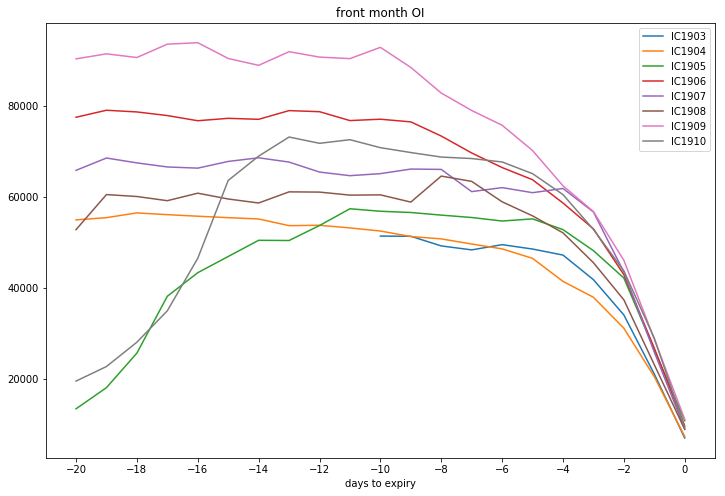

In [75]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for contract in oiData['contract'].unique():
    ax.plot(oiData[oiData['contract'] == contract]['remainDays'], oiData[oiData['contract'] == contract]['oi'], label=contract)

ax.set_xticks(np.arange(-20, 2, 2))
ax.set_xlabel('days to expiry')
ax.set_title('front month OI')
ax.legend();

In [23]:
oiData

,contract,date,oi,consDay,expDate,expConsDay
0,IC1903,2019-03-01,51428.983333,0,2019-03-15,10.0
1,IC1903,2019-03-04,51381.316667,1,2019-03-15,10.0
2,IC1903,2019-03-05,49263.479167,2,2019-03-15,10.0
3,IC1903,2019-03-06,48388.737500,3,2019-03-15,10.0
4,IC1903,2019-03-07,49538.745833,4,2019-03-15,10.0
5,IC1903,2019-03-08,48574.729167,5,2019-03-15,10.0
6,IC1903,2019-03-11,47249.241667,6,2019-03-15,10.0
7,IC1903,2019-03-12,41840.183333,7,2019-03-15,10.0
8,IC1903,2019-03-13,34075.612500,8,2019-03-15,10.0
9,IC1903,2019-03-14,21068.675000,9,2019-03-15,10.0


In [17]:
expiryData

,contr_name,expDate,firstDate,contract
0,CFFEX1709,2017-09-15,20170123,IC1709
1,CFFEX1710,2017-10-20,20170821,IC1710
2,CFFEX1711,2017-11-17,20170918,IC1711
3,CFFEX1712,2017-12-15,20170424,IC1712
4,CFFEX1801,2018-01-19,20171120,IC1801
5,CFFEX1802,2018-02-22,20171218,IC1802
6,CFFEX1803,2018-03-16,20170724,IC1803
7,CFFEX1804,2018-04-20,20180223,IC1804
8,CFFEX1805,2018-05-18,20180319,IC1805
9,CFFEX1806,2018-06-15,20171023,IC1806


In [11]:
oiData

,contract,date,oi
0,IC1903,2019-03-01,51428.983333
1,IC1903,2019-03-04,51381.316667
2,IC1903,2019-03-05,49263.479167
3,IC1903,2019-03-06,48388.737500
4,IC1903,2019-03-07,49538.745833
5,IC1903,2019-03-08,48574.729167
6,IC1903,2019-03-11,47249.241667
7,IC1903,2019-03-12,41840.183333
8,IC1903,2019-03-13,34075.612500
9,IC1903,2019-03-14,21068.675000


In [8]:
readPath = r'\\192.168.10.217\shareWithBenny\tickData_cffex'
expiryData = pd.read_csv(os.path.join(readPath, 'expiryTable.csv'))
expiryData

,contr_name,expDate,firstDate
0,CFFEX1709,20170915,20170123
1,CFFEX1710,20171020,20170821
2,CFFEX1711,20171117,20170918
3,CFFEX1712,20171215,20170424
4,CFFEX1801,20180119,20171120
5,CFFEX1802,20180222,20171218
6,CFFEX1803,20180316,20170724
7,CFFEX1804,20180420,20180223
8,CFFEX1805,20180518,20180319
9,CFFEX1806,20180615,20171023


In [7]:
oiData

,date,openInterest,contract
0,2019-03-01 09:31:00,55211,IC1903
1,2019-03-01 09:32:00,54905,IC1903
2,2019-03-01 09:33:00,54745,IC1903
3,2019-03-01 09:34:00,54516,IC1903
4,2019-03-01 09:35:00,54353,IC1903
5,2019-03-01 09:36:00,54186,IC1903
6,2019-03-01 09:37:00,53952,IC1903
7,2019-03-01 09:38:00,53797,IC1903
8,2019-03-01 09:39:00,53619,IC1903
9,2019-03-01 09:40:00,53483,IC1903
